### Ejercicios de Anomalías para detectar fraudes en tarjetas de crédito

Basado en Shirin Glander Pag personal :https://shiring.github.io/about

In [1]:
options(repr.plot.width=4, repr.plot.height=3)

### Bajar de Kaggle


In [2]:
unzip("creditcard.csv.zip")

In [3]:
creditcard <- read.csv("creditcard.csv")

In [4]:
str(creditcard)

'data.frame':	284807 obs. of  31 variables:
 $ Time  : num  0 0 1 1 2 2 4 7 7 9 ...
 $ V1    : num  -1.36 1.192 -1.358 -0.966 -1.158 ...
 $ V2    : num  -0.0728 0.2662 -1.3402 -0.1852 0.8777 ...
 $ V3    : num  2.536 0.166 1.773 1.793 1.549 ...
 $ V4    : num  1.378 0.448 0.38 -0.863 0.403 ...
 $ V5    : num  -0.3383 0.06 -0.5032 -0.0103 -0.4072 ...
 $ V6    : num  0.4624 -0.0824 1.8005 1.2472 0.0959 ...
 $ V7    : num  0.2396 -0.0788 0.7915 0.2376 0.5929 ...
 $ V8    : num  0.0987 0.0851 0.2477 0.3774 -0.2705 ...
 $ V9    : num  0.364 -0.255 -1.515 -1.387 0.818 ...
 $ V10   : num  0.0908 -0.167 0.2076 -0.055 0.7531 ...
 $ V11   : num  -0.552 1.613 0.625 -0.226 -0.823 ...
 $ V12   : num  -0.6178 1.0652 0.0661 0.1782 0.5382 ...
 $ V13   : num  -0.991 0.489 0.717 0.508 1.346 ...
 $ V14   : num  -0.311 -0.144 -0.166 -0.288 -1.12 ...
 $ V15   : num  1.468 0.636 2.346 -0.631 0.175 ...
 $ V16   : num  -0.47 0.464 -2.89 -1.06 -0.451 ...
 $ V17   : num  0.208 -0.115 1.11 -0.684 -0.237 ...
 $ V

### Entendimieto y Pre-Procesamiento

In [5]:
library(dplyr)
library(ggplot2)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.3.3"

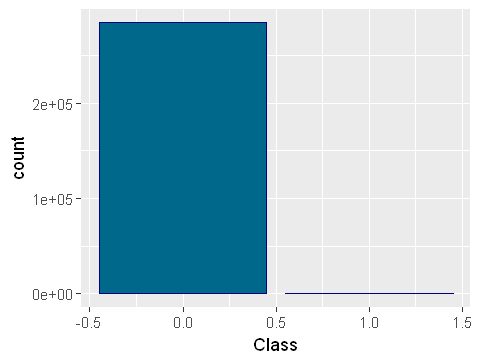

In [6]:
creditcard %>%
  ggplot(aes(x = Class)) +
    geom_bar(color = "navy", fill = "deepskyblue4")

In [7]:
summary(creditcard$Time)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0   54200   84690   94810  139300  172800 

In [8]:
# separate transactions by day
creditcard$day <- ifelse(creditcard$Time > 3600 * 24, "day2", "day1")

In [9]:
# make transaction relative to day
creditcard$Time_day <- ifelse(creditcard$day == "day2", creditcard$Time - 86400, creditcard$Time)

In [10]:
summary(creditcard[creditcard$day == "day1", ]$Time_day)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0   38430   54690   52950   70980   86400 

In [11]:
summary(creditcard[creditcard$day == "day2", ]$Time_day)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1   37840   53420   51710   68180   86390 

In [12]:
# bin transactions according to time of day
creditcard$Time <- as.factor(ifelse(creditcard$Time_day <= 38138, "gr1", # mean 1st Qu.
                          ifelse(creditcard$Time_day <= 52327, "gr2", # mean mean
                                 ifelse(creditcard$Time_day <= 69580, "gr3", # mean 3rd Qu
                                        "gr4"))))

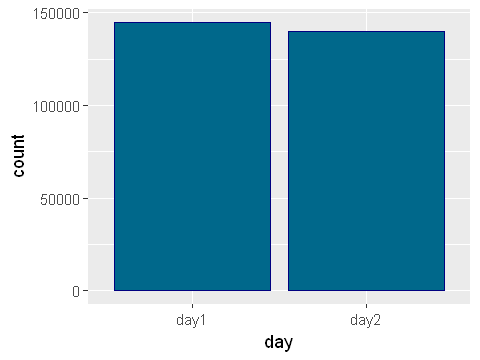

In [13]:
creditcard %>%
  ggplot(aes(x = day)) +
    geom_bar(color = "navy", fill = "deepskyblue4") 

In [14]:
creditcard <- select(creditcard, -Time_day, -day)


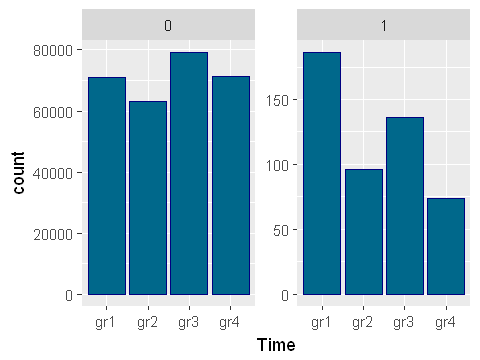

In [15]:
# convert class variable to factor
creditcard$Class <- factor(creditcard$Class)
creditcard %>%
  ggplot(aes(x = Time)) +
    geom_bar(color = "navy", fill = "deepskyblue4") +
    facet_wrap( ~ Class, scales = "free", ncol = 2)

In [16]:
summary(creditcard[creditcard$Class == "0", ]$Amount)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     5.65    22.00    88.29    77.05 25690.00 

In [17]:
summary(creditcard[creditcard$Class == "1", ]$Amount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    9.25  122.20  105.90 2126.00 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


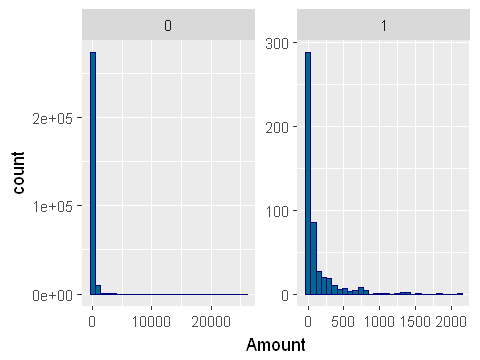

In [18]:
creditcard %>%
  ggplot(aes(x = Amount)) +
    geom_histogram(color = "navy", fill = "deepskyblue4") +
    facet_wrap( ~ Class, scales = "free", ncol = 2)

### Modelameinto

In [50]:
library(h2o)
h2o.init(nthreads = 1)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         26 minutes 42 seconds 
    H2O cluster version:        3.10.4.4 
    H2O cluster version age:    16 days  
    H2O cluster name:           H2O_started_from_R_admin_wwf296 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   2.47 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 3.3.1 (2016-06-21) 



In [20]:
# convert data to H2OFrame
creditcard_hf <- as.h2o(creditcard)

  |======================================================================| 100%


In [21]:
splits <- h2o.splitFrame(creditcard_hf, 
                         ratios = c(0.4, 0.4), 
                         seed = 42)

train_unsupervised  <- splits[[1]]
train_supervised  <- splits[[2]]
test <- splits[[3]]

response <- "Class"
features <- setdiff(colnames(train_unsupervised), response)

### Autoencoders


In [22]:
model_nn <- h2o.deeplearning(x = features,
                             training_frame = train_unsupervised,
                             model_id = "model_nn",
                             autoencoder = TRUE,
                             reproducible = TRUE, #slow - turn off for real problems
                             ignore_const_cols = FALSE,
                             seed = 42,
                             hidden = c(10, 2, 10), 
                             epochs = 100,
                             activation = "Tanh")

  |======================================================================| 100%


In [23]:
h2o.saveModel(model_nn, path='C:/Users/admin/Desktop/GitHub/Mineria.de.Datos.Aplicada/Detención Anomalias',force = TRUE)


[1] "C:\\Users\\admin\\Desktop\\GitHub\\Mineria.de.Datos.Aplicada\\Detenci? Anomalias\\model_nn"

In [24]:
model_nn <- h2o.loadModel("model_nn/model_nn")
model_nn

Model Details:

H2OAutoEncoderModel: deeplearning
Model ID:  model_nn 
Status of Neuron Layers: auto-encoder, gaussian distribution, Quadratic loss, 776 weights/biases, 16,0 KB, 3.078.999 training samples, mini-batch size 1
  layer units  type dropout       l1       l2 mean_rate rate_rms momentum
1     1    34 Input  0.00 %                                              
2     2    10  Tanh  0.00 % 0.000000 0.000000  0.828081 0.245066 0.000000
3     3     2  Tanh  0.00 % 0.000000 0.000000  0.063982 0.108885 0.000000
4     4    10  Tanh  0.00 % 0.000000 0.000000  0.159982 0.176786 0.000000
5     5    34  Tanh         0.000000 0.000000  0.363700 0.415370 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2   -0.056359   0.803946 -0.107397 1.518055
3   -0.082333   0.364984  0.247254 0.104044
4    0.201821   1.226047  0.080519 0.669157
5    0.011648   0.680734  0.048081 0.724575


H2OAutoEncoderMetrics: deeplearning
** Reported on training data. 

In [25]:
#Convert to autoencoded representation
test_autoenc <- h2o.predict(model_nn, test)

  |======================================================================| 100%


### Reducción de Dimensionalidad con Capas Ocultas

In [26]:
train_features <- h2o.deepfeatures(model_nn, train_unsupervised, layer = 2) %>%
  as.data.frame() %>%
  mutate(Class = as.vector(train_unsupervised[, 31]))


  |======================================================================| 100%


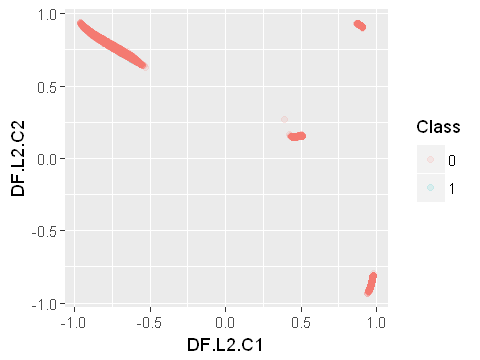

In [27]:
ggplot(train_features, aes(x = DF.L2.C1, y = DF.L2.C2, color = Class)) +
  geom_point(alpha = 0.1)

In [28]:
# let's take the third hidden layer
train_features <- h2o.deepfeatures(model_nn, train_unsupervised, layer = 3) %>%
  as.data.frame() %>%
  mutate(Class = as.factor(as.vector(train_unsupervised[, 31]))) %>%
  as.h2o()
features_dim <- setdiff(colnames(train_features), response)

  |======================================================================| 100%
  |======================================================================| 100%


In [29]:
model_nn_dim <- h2o.deeplearning(y = response,
                               x = features_dim,
                               training_frame = train_features,
                               reproducible = TRUE, #slow - turn off for real problems
                               balance_classes = TRUE,
                               ignore_const_cols = FALSE,
                               seed = 42,
                               hidden = c(10, 2, 10), 
                               epochs = 100,
                               activation = "Tanh")

  |======================================================================| 100%


In [30]:
h2o.saveModel(model_nn_dim, path="model_nn_dim", force = TRUE)

[1] "C:\\Users\\admin\\Desktop\\GitHub\\Mineria.de.Datos.Aplicada\\DetenciÃ³n Anomalias\\model_nn_dim\\DeepLearning_model_R_1493676616333_1"

In [31]:
model_nn_dim <- h2o.loadModel("model_nn_dim/DeepLearning_model_R_1493672949388_1")
model_nn_dim

Model Details:

H2OBinomialModel: deeplearning
Model ID:  DeepLearning_model_R_1493672949388_1 
Status of Neuron Layers: predicting Class, 2-class classification, bernoulli distribution, CrossEntropy loss, 184 weights/biases, 7,1 KB, 4.553.360 training samples, mini-batch size 1
  layer units    type dropout       l1       l2 mean_rate rate_rms momentum
1     1    10   Input  0.00 %                                              
2     2    10    Tanh  0.00 % 0.000000 0.000000  0.012031 0.021979 0.000000
3     3     2    Tanh  0.00 % 0.000000 0.000000  0.000312 0.000134 0.000000
4     4    10    Tanh  0.00 % 0.000000 0.000000  0.225957 0.111415 0.000000
5     5     2 Softmax         0.000000 0.000000  0.135322 0.065438 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2   -0.219937   3.051839  0.781291 1.703607
3   -0.301697   1.402969 -2.696903 0.403040
4    0.128050   1.998901 -0.361804 1.089969
5    0.563946   1.052547  0.000000 0.131943


In [32]:
test_dim <- h2o.deepfeatures(model_nn, test, layer = 3)
h2o.predict(model_nn_dim, test_dim) %>%
  as.data.frame() %>%
  mutate(actual = as.vector(test[, 31])) %>%
  group_by(actual, predict) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n))

  |======================================================================| 100%
  |======================================================================| 100%


actual,predict,n,freq
0,0,17616,0.31106088
0,1,39016,0.68893912
1,0,2,0.02173913
1,1,90,0.97826087


### Detección de Anomalias

In [33]:
anomaly <- h2o.anomaly(model_nn, test) %>%
  as.data.frame() %>%
  tibble::rownames_to_column() %>%
  mutate(Class = as.vector(test[, 31]))

In [34]:
mean_mse <- anomaly %>%
  group_by(Class) %>%
  summarise(mean = mean(Reconstruction.MSE))

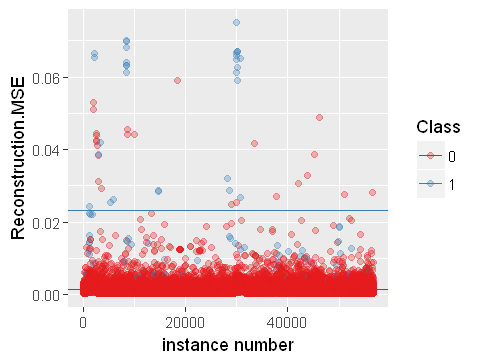

In [35]:
ggplot(anomaly, aes(x = as.numeric(rowname), y = Reconstruction.MSE, color = as.factor(Class))) +
  geom_point(alpha = 0.3) +
  geom_hline(data = mean_mse, aes(yintercept = mean, color = Class)) +
  scale_color_brewer(palette = "Set1") +
  labs(x = "instance number",
       color = "Class")

In [36]:
anomaly <- anomaly %>%
  mutate(outlier = ifelse(Reconstruction.MSE > 0.02, "outlier", "no_outlier"))

In [37]:
anomaly %>%
  group_by(Class, outlier) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n)) 

Class,outlier,n,freq
0,no_outlier,56602,0.9994702642
0,outlier,30,0.0005297358
1,no_outlier,60,0.6521739130
1,outlier,32,0.3478260870


### Modelo Supervisado Pre-Entrenado

In [38]:
model_nn_2 <- h2o.deeplearning(y = response,
                               x = features,
                               training_frame = train_supervised,
                               pretrained_autoencoder  = "model_nn",
                               reproducible = TRUE, #slow - turn off for real problems
                               balance_classes = TRUE,
                               ignore_const_cols = FALSE,
                               seed = 42,
                               hidden = c(10, 2, 10), 
                               epochs = 100,
                               activation = "Tanh")

  |======================================================================| 100%


In [39]:
h2o.saveModel(model_nn_2, path="model_nn_2", force = TRUE)

[1] "C:\\Users\\admin\\Desktop\\GitHub\\Mineria.de.Datos.Aplicada\\DetenciÃ³n Anomalias\\model_nn_2\\DeepLearning_model_R_1493676616333_23"

In [40]:
model_nn_2 <- h2o.loadModel("model_nn_2/DeepLearning_model_R_1493672949388_23")
model_nn_2

Model Details:

H2OBinomialModel: deeplearning
Model ID:  DeepLearning_model_R_1493672949388_23 
Status of Neuron Layers: predicting Class, 2-class classification, bernoulli distribution, CrossEntropy loss, 424 weights/biases, 11,7 KB, 13.889.883 training samples, mini-batch size 1
  layer units    type dropout       l1       l2 mean_rate rate_rms momentum
1     1    34   Input  0.00 %                                              
2     2    10    Tanh  0.00 % 0.000000 0.000000  0.793635 0.332953 0.000000
3     3     2    Tanh  0.00 % 0.000000 0.000000  0.851693 0.175319 0.000000
4     4    10    Tanh  0.00 % 0.000000 0.000000  0.998776 0.009405 0.000000
5     5     2 Softmax         0.000000 0.000000  0.626231 0.398185 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2   -0.012780   1.356666 -0.108627 2.400342
3   -0.035225   0.993426 -0.266087 1.856786
4    0.815884   2.005008  0.784216 0.980405
5   -3.064094   5.676661  8.691606 7.2136

In [41]:
pred <- as.data.frame(h2o.predict(object = model_nn_2, newdata = test)) %>%
  mutate(actual = as.vector(test[, 31]))

  |======================================================================| 100%


In [42]:
pred %>%
  group_by(actual, predict) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n)) 

actual,predict,n,freq
0,0,56594,0.9993290013
0,1,38,0.0006709987
1,0,16,0.1739130435
1,1,76,0.8260869565


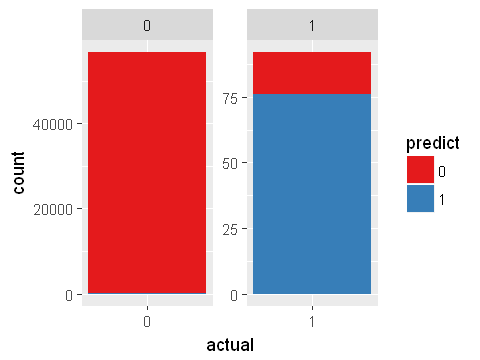

In [43]:
pred %>%
  ggplot(aes(x = actual, fill = predict)) +
    geom_bar() +
    scale_fill_brewer(palette = "Set1") +
    facet_wrap( ~ actual, scales = "free", ncol = 2)

### Medición del rendimiento del modelo en datos desbalanceados

In [44]:
library(ROCR)

# http://stackoverflow.com/questions/24563061/computing-integral-of-a-line-plot-in-r
line_integral <- function(x, y) {
  dx <- diff(x)
  end <- length(y)
  my <- (y[1:(end - 1)] + y[2:end]) / 2
  sum(dx * my)
} 

Warning message:
"package 'ROCR' was built under R version 3.3.3"Loading required package: gplots
Warning message:
"package 'gplots' was built under R version 3.3.2"
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



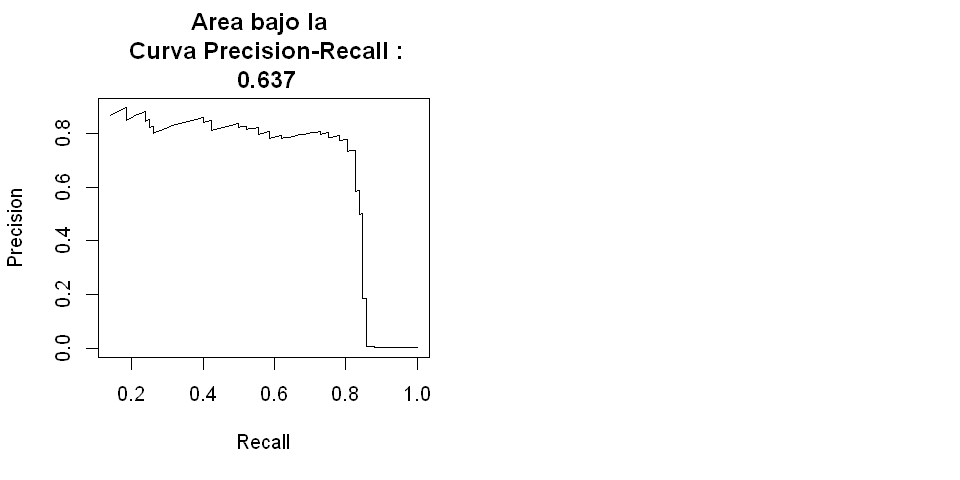

In [45]:
prediction_obj <- prediction(pred$p1, pred$actual)
par(mfrow = c(1, 2))
par(mar = c(5.1,4.1,4.1,2.1))

# precision-recall curve
perf1 <- performance(prediction_obj, measure = "prec", x.measure = "rec") 

x <- perf1@x.values[[1]]
y <- perf1@y.values[[1]]
y[1] <- 0

options(repr.plot.width=8, repr.plot.height=4)

plot(perf1, main = paste("Area bajo la \n Curva Precision-Recall :\n", round(abs(line_integral(x,y)), digits = 3)))

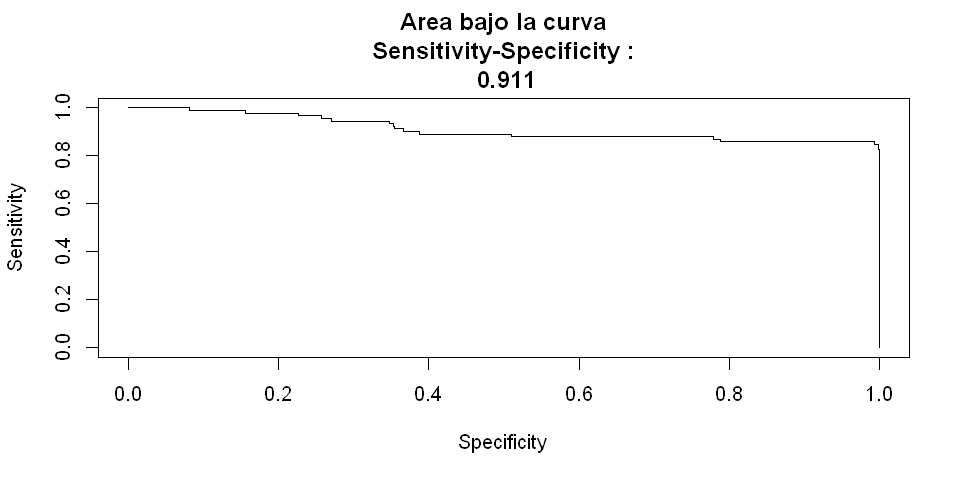

In [46]:
# sensitivity-specificity curve
perf2 <- performance(prediction_obj, measure = "sens", x.measure = "spec") 

x <- perf2@x.values[[1]]
y <- perf2@y.values[[1]]
y[1] <- 0

plot(perf2, main = paste("Area bajo la curva\nSensitivity-Specificity :\n", round(abs(line_integral(x,y)), digits = 3)))

In [47]:
thresholds <- seq(from = 0, to = 1, by = 0.1)
pred_thresholds <- data.frame(actual = pred$actual)

for (threshold in thresholds) {
  
  prediction <- ifelse(pred$p1 > threshold, 1, 0)
  prediction_true <- ifelse(pred_thresholds$actual == prediction, TRUE, FALSE)
  pred_thresholds <- cbind(pred_thresholds, prediction_true)

}


Warning message:
"package 'tidyverse' was built under R version 3.3.3"Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Warning message:
"package 'tibble' was built under R version 3.3.2"Warning message:
"package 'tidyr' was built under R version 3.3.2"Warning message:
"package 'purrr' was built under R version 3.3.2"Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


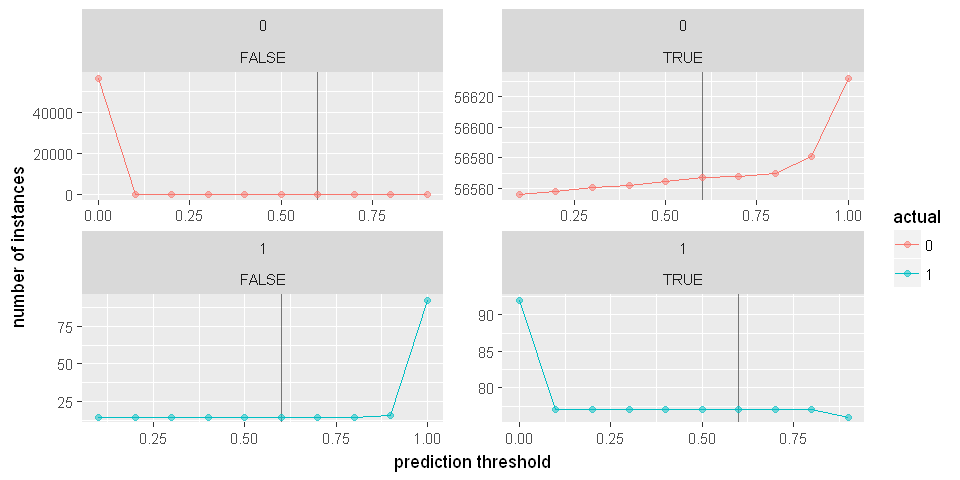

In [48]:
colnames(pred_thresholds)[-1] <- thresholds

library(tidyverse)

pred_thresholds %>%
  gather(x, y, 2:ncol(pred_thresholds)) %>%
  group_by(actual, x, y) %>%
  summarise(n = n()) %>%
  ggplot(aes(x = as.numeric(x), y = n, color = actual)) +
    geom_vline(xintercept = 0.6, alpha = 0.5) +
    geom_line() +
    geom_point(alpha = 0.5) +
    facet_wrap(actual ~ y, scales = "free", ncol = 2) +
    labs(x = "prediction threshold",
         y = "number of instances")

In [49]:
pred %>%
  mutate(predict = ifelse(pred$p1 > 0.6, 1, 0)) %>%
  group_by(actual, predict) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n))

actual,predict,n,freq
0,0,56567,0.998852239
0,1,65,0.001147761
1,0,15,0.163043478
1,1,77,0.836956522
